In [1]:
import os

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import faiss
import torch
import umap
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.decomposition import PCA

Using backend: pytorch


In [3]:
dataset = DglNodePropPredDataset('ogbn-arxiv', root='../../data/dataset_dgl')
graph = dataset[0][0]
graph.add_edges(graph.edges()[1], graph.edges()[0])

In [4]:
output_emb_file = '../../models/graphsage_link_pred/full_graphsage_linkpred_46_h.npy'

In [5]:
embeddings = np.load(output_emb_file)
embeddings.shape

(169343, 50)

## L2 Distance

In [6]:
index = faiss.IndexFlatL2(embeddings.shape[1])

In [7]:
index.train(embeddings)
index.add(embeddings)

In [8]:
index

<faiss.swigfaiss.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x7efe3c715780> >

In [9]:
index.ntotal

169343

### Check if the closest embedding is a neighbor

In [10]:
distances, indices = index.search(embeddings, 2)

In [11]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(85884)

In [12]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [13]:
max_k = 100
distances, indices = index.search(embeddings, max_k + 1)

In [14]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [15]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

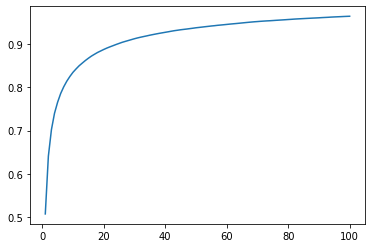

In [16]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [17]:
percentages

tensor([0.5072, 0.6407, 0.7022, 0.7400, 0.7654, 0.7857, 0.8012, 0.8143, 0.8251,
        0.8347, 0.8425, 0.8498, 0.8559, 0.8618, 0.8672, 0.8722, 0.8765, 0.8806,
        0.8841, 0.8875, 0.8907, 0.8936, 0.8962, 0.8990, 0.9015, 0.9041, 0.9062,
        0.9083, 0.9103, 0.9124, 0.9143, 0.9159, 0.9175, 0.9190, 0.9206, 0.9220,
        0.9234, 0.9248, 0.9260, 0.9273, 0.9285, 0.9298, 0.9310, 0.9321, 0.9331,
        0.9340, 0.9348, 0.9358, 0.9367, 0.9377, 0.9385, 0.9394, 0.9402, 0.9410,
        0.9418, 0.9425, 0.9434, 0.9441, 0.9447, 0.9455, 0.9462, 0.9469, 0.9475,
        0.9482, 0.9489, 0.9496, 0.9503, 0.9510, 0.9516, 0.9521, 0.9527, 0.9532,
        0.9536, 0.9540, 0.9545, 0.9550, 0.9554, 0.9559, 0.9563, 0.9568, 0.9573,
        0.9578, 0.9582, 0.9586, 0.9590, 0.9594, 0.9597, 0.9601, 0.9605, 0.9608,
        0.9613, 0.9616, 0.9620, 0.9625, 0.9628, 0.9631, 0.9635, 0.9638, 0.9641,
        0.9644])

In [18]:
percentages.max()

tensor(0.9644)

### Percentage of same class neighbors by neighborhood size

In [19]:
y = dataset[0][1][:, 0]

In [20]:
label_dict = {idx: val for idx, val in enumerate(y.numpy())}

In [21]:
label_transform = np.vectorize(label_dict.get)

In [22]:
ind_labels = label_transform(indices)

In [23]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [24]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [25]:
perc_same_class = n_same_class / n_total

In [26]:
perc_same_class

array([0.68670686, 0.67380701, 0.66410382, 0.65652108, 0.64934836,
       0.64322804, 0.63811655, 0.63351157, 0.62941354, 0.62587766,
       0.62253909, 0.61940312, 0.61656292, 0.61384502, 0.6114147 ,
       0.6090575 , 0.60691892, 0.60492019, 0.60311352, 0.60128851,
       0.59961763, 0.59799611, 0.59650763, 0.59500737, 0.59358863,
       0.59224791, 0.59098114, 0.58977616, 0.58859096, 0.58746725,
       0.58637356, 0.58533236, 0.58432044, 0.58338923, 0.58244645,
       0.5815147 , 0.58059486, 0.57974177, 0.57890744, 0.57810922,
       0.57729895, 0.57649591, 0.57576923, 0.57503531, 0.57432876,
       0.57363881, 0.57296792, 0.57229976, 0.5716379 , 0.57098362,
       0.57041197, 0.56978463, 0.56918664, 0.56863071, 0.56805816,
       0.56748054, 0.56692495, 0.56638577, 0.56584865, 0.56531881,
       0.56482018, 0.5643185 , 0.56382177, 0.56333374, 0.56284691,
       0.56235122, 0.56187817, 0.56140765, 0.56096575, 0.56051581,
       0.56007629, 0.55961889, 0.55917078, 0.55875984, 0.55832

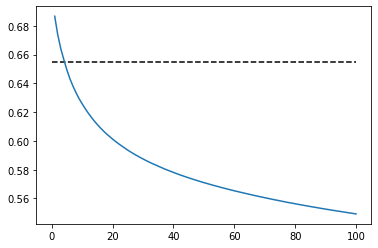

In [27]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Cossine Distance

In [28]:
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]

In [29]:
index_cos = faiss.IndexFlatIP(emb_norm.shape[1])

In [30]:
index_cos.train(emb_norm)
index_cos.add(emb_norm)

In [31]:
index_cos

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7efd5002fd80> >

In [32]:
index_cos.ntotal

169343

### Check if the closest embedding is a neighbor

In [33]:
distances, indices = index_cos.search(emb_norm, 2)

In [34]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(89455)

In [35]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [36]:
(sum(emb_norm[0] * emb_norm[411]) + 1) / 2

0.9009325060033007

In [88]:
max_k = 1000
distances, indices = index_cos.search(emb_norm, max_k + 1)

In [89]:
indices

array([[     0,  79872,  10839, ..., 106517, 149615,  30907],
       [     1, 154949, 100594, ..., 134543,   1069, 155292],
       [     2,  65576, 113232, ...,  78264, 115159,  57190],
       ...,
       [169340,  61320,  18094, ..., 138785,  30838,  95201],
       [169341,  34227, 128974, ...,   7176, 142359,  57690],
       [169342,  17652, 127946, ...,  39493,  73990, 105412]])

In [90]:
sum(emb_norm[0] * emb_norm[411])

0.8018650120066013

In [91]:
distances

array([[1.0000001 , 0.99413663, 0.9913514 , ..., 0.8929655 , 0.8929332 ,
        0.89254105],
       [1.        , 0.977219  , 0.95866674, ..., 0.45639008, 0.45632267,
        0.45627272],
       [1.0000001 , 0.97858226, 0.978446  , ..., 0.7871869 , 0.78705686,
        0.7870111 ],
       ...,
       [0.99999976, 0.96442336, 0.95919424, ..., 0.7038354 , 0.70374984,
        0.7037371 ],
       [1.        , 0.9899185 , 0.9888157 , ..., 0.8781184 , 0.8780388 ,
        0.877989  ],
       [0.99999976, 0.96207434, 0.95836735, ..., 0.4724388 , 0.47222328,
        0.47221145]], dtype=float32)

In [92]:
has_neighbor = torch.zeros((emb_norm.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [93]:
has_neighbor

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [0., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

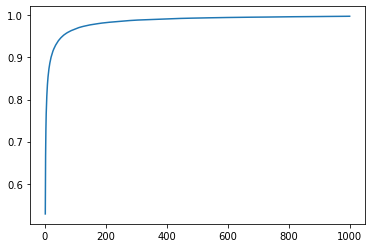

In [94]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [95]:
percentages

tensor([0.5282, 0.6666, 0.7286, 0.7665, 0.7905, 0.8086, 0.8235, 0.8355, 0.8455,
        0.8539, 0.8611, 0.8674, 0.8732, 0.8781, 0.8827, 0.8868, 0.8905, 0.8942,
        0.8973, 0.9006, 0.9031, 0.9060, 0.9085, 0.9109, 0.9129, 0.9150, 0.9170,
        0.9187, 0.9204, 0.9220, 0.9235, 0.9251, 0.9267, 0.9281, 0.9294, 0.9306,
        0.9319, 0.9331, 0.9344, 0.9354, 0.9365, 0.9377, 0.9388, 0.9398, 0.9407,
        0.9415, 0.9425, 0.9434, 0.9442, 0.9451, 0.9459, 0.9467, 0.9474, 0.9481,
        0.9489, 0.9495, 0.9501, 0.9508, 0.9514, 0.9520, 0.9527, 0.9534, 0.9539,
        0.9546, 0.9550, 0.9556, 0.9562, 0.9567, 0.9571, 0.9575, 0.9580, 0.9584,
        0.9588, 0.9593, 0.9597, 0.9600, 0.9603, 0.9607, 0.9611, 0.9614, 0.9619,
        0.9623, 0.9627, 0.9631, 0.9634, 0.9638, 0.9641, 0.9643, 0.9647, 0.9651,
        0.9654, 0.9658, 0.9661, 0.9664, 0.9666, 0.9669, 0.9673, 0.9676, 0.9679,
        0.9682, 0.9684, 0.9687, 0.9690, 0.9692, 0.9695, 0.9697, 0.9699, 0.9702,
        0.9704, 0.9706, 0.9709, 0.9711, 

### Percentage of same class neighbors by neighborhood size

In [96]:
ind_labels = label_transform(indices)

In [97]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [98]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [99]:
perc_same_class = n_same_class / n_total

In [100]:
perc_same_class

array([0.68512427, 0.67234843, 0.66205669, 0.65367774, 0.6466745 ,
       0.64065044, 0.63553009, 0.63080331, 0.62653182, 0.62278157,
       0.61961066, 0.6165027 , 0.61361215, 0.61085784, 0.60830031,
       0.60596947, 0.60369643, 0.60160509, 0.59970375, 0.59787502,
       0.59615551, 0.59450239, 0.59293808, 0.59140128, 0.58998695,
       0.58867369, 0.58737504, 0.58609766, 0.58496111, 0.58380624,
       0.58267235, 0.58158442, 0.58056314, 0.57957466, 0.57855477,
       0.57763714, 0.57674261, 0.57585523, 0.57502805, 0.57421417,
       0.57342689, 0.5726307 , 0.57186096, 0.57111105, 0.57037479,
       0.56966296, 0.56896157, 0.56826357, 0.56756948, 0.56692181,
       0.5662787 , 0.56567906, 0.56507753, 0.56442721, 0.56381567,
       0.56322006, 0.56265841, 0.56211908, 0.5615667 , 0.56100538,
       0.56046904, 0.55994762, 0.5594376 , 0.55893853, 0.55844565,
       0.55794641, 0.55744814, 0.5569561 , 0.55647542, 0.5560288 ,
       0.55558079, 0.5551385 , 0.55469975, 0.55425411, 0.55383

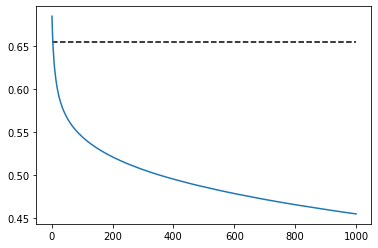

In [101]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

### Percentage of same class neighbors by angular section

In [102]:
distance_list = np.linspace(0.99, 0.5, 50)
distance_list

array([0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.9 , 0.89,
       0.88, 0.87, 0.86, 0.85, 0.84, 0.83, 0.82, 0.81, 0.8 , 0.79, 0.78,
       0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.71, 0.7 , 0.69, 0.68, 0.67,
       0.66, 0.65, 0.64, 0.63, 0.62, 0.61, 0.6 , 0.59, 0.58, 0.57, 0.56,
       0.55, 0.54, 0.53, 0.52, 0.51, 0.5 ])

In [103]:
perc_section_same_class = np.zeros(distance_list.shape)
n_section_neighbors = np.zeros(distance_list.shape)
n_section_same_class = np.zeros(distance_list.shape)
for idx, dist in enumerate(distance_list):
    n_section_neighbors[idx] = (distances > dist)[:, 1:].sum()
    n_section_same_class[idx] = (is_same_class * (distances > dist)[:, 1:]).sum()
    perc_section_same_class[idx] = n_section_same_class[idx] / n_section_neighbors[idx]
perc_section_same_class

array([0.71708426, 0.77163927, 0.77091554, 0.76180688, 0.75330952,
       0.74612106, 0.73946507, 0.73375142, 0.7288265 , 0.72424071,
       0.72021286, 0.71688727, 0.71372898, 0.71039248, 0.70696842,
       0.70321006, 0.69901826, 0.69449389, 0.68951019, 0.68416995,
       0.67872223, 0.67327888, 0.66780611, 0.66237512, 0.65692844,
       0.65152404, 0.6461301 , 0.64078866, 0.63548151, 0.6302523 ,
       0.62507809, 0.61987732, 0.61470207, 0.60959004, 0.60444653,
       0.59923553, 0.59389521, 0.58844243, 0.58280325, 0.57695513,
       0.57083522, 0.56443996, 0.55773246, 0.55067471, 0.54324142,
       0.53534837, 0.52701201, 0.5182026 , 0.50898576, 0.49944108])

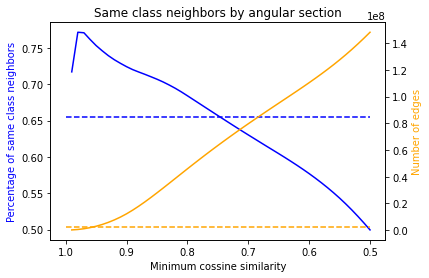

In [104]:
fig, ax1 = plt.subplots()
ax1.set_title('Same class neighbors by angular section')
ax1.set_ylabel('Percentage of same class neighbors', color='blue')
ax1.set_xlabel('Minimum cossine similarity')
ax1.invert_xaxis()
ax1.plot(distance_list, perc_section_same_class, color='blue')
ax1.hlines(0.6551, 1, 0.5, color='blue', ls='--')

ax2 = ax1.twinx()
ax2.set_ylabel('Number of edges', color='orange')
ax2.plot(distance_list, n_section_neighbors, color='orange')
ax2.hlines(graph.edges()[0].shape[0], 1, 0.5, color='orange', ls='--')

#### Evaluating a single threshold

In [105]:
thresh = 0.8

Number of isolated nodes

In [106]:
(((distances > thresh)[:, 1:] * 1)[:,0] == 0).sum()

23369

Number of connected nodes

In [107]:
(((distances > thresh)[:, 1:] * 1)[:,0] == 1).sum()

145974

Number of edges

In [110]:
((distances > thresh)[:, 1:] * 1).sum()

12197899

Number of edges in the graph - Undirected

In [111]:
graph.edges()[0].shape[0]

2332486

Degree distribution

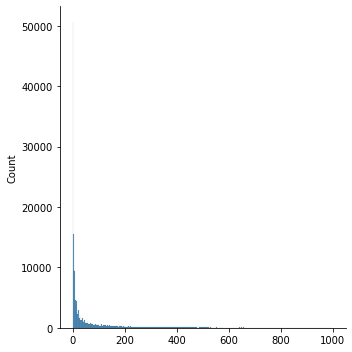

In [108]:
degree_dist = ((distances > thresh)[:, 1:] * 1).sum(axis=1)
sns.displot(degree_dist)

## Inner Product

In [58]:
index_ip = faiss.IndexFlatIP(embeddings.shape[1])

In [59]:
index_ip.train(embeddings)
index_ip.add(embeddings)

In [60]:
index_ip

<faiss.swigfaiss.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7efd1b62be40> >

In [61]:
index_ip.ntotal

169343

### Check if the closest embedding is a neighbor

In [62]:
distances, indices = index_ip.search(embeddings, 2)

In [63]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).sum()

tensor(8248)

In [64]:
graph.has_edges_between(indices[:, 0], indices[:, 1]).all()

tensor(False)

### Check if there is a neighbor in the n closest embeddings

In [65]:
(sum(embeddings[0] * embeddings[411]) + 1) / 2

3.5091501633287407

In [66]:
max_k = 100
distances, indices = index_ip.search(embeddings, max_k + 1)

In [67]:
indices

array([[113109,  29771,   8856, ...,  27610,  19066,  61964],
       [100594,      1, 165535, ..., 135066,  34635,  79439],
       [165599,  53322,  92659, ...,  50471,  63120, 112636],
       ...,
       [ 77402, 111649,  14350, ...,  11018, 132029,  67589],
       [ 29771, 113109,   8856, ...,  31358,  27644,  61964],
       [ 19915,  31444,  11767, ...,  20914,  85416, 144660]])

In [68]:
sum(embeddings[0] * embeddings[411])

6.0183003266574815

In [69]:
distances

array([[11.687261 , 11.663428 , 11.53837  , ...,  8.009147 ,  8.00374  ,
         8.000391 ],
       [19.034279 , 16.770588 , 16.564154 , ..., 10.438839 , 10.410306 ,
        10.395725 ],
       [16.360086 , 16.200884 , 16.13301  , ..., 12.567054 , 12.549891 ,
        12.542378 ],
       ...,
       [ 9.456102 ,  9.417308 ,  9.166076 , ...,  7.92332  ,  7.922757 ,
         7.916923 ],
       [12.126884 , 11.983477 , 11.756733 , ...,  8.9544525,  8.94658  ,
         8.944587 ],
       [32.23208  , 32.17056  , 32.145916 , ..., 18.176947 , 18.149397 ,
        18.109789 ]], dtype=float32)

In [70]:
has_neighbor = torch.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    if j == 0:
        has_neighbor[:, j] = graph.has_edges_between(indices[:, 0], indices[:, j + 1])
    else:
        has_neighbor[:, j] = torch.max(
            has_neighbor[:, j - 1],
            graph.has_edges_between(indices[:, 0], indices[:, j + 1]))

In [71]:
has_neighbor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

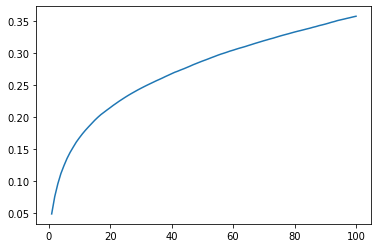

In [72]:
percentages = has_neighbor.sum(dim=0) / embeddings.shape[0]
plt.plot(list(range(1, max_k + 1)), percentages)

In [73]:
percentages

tensor([0.0487, 0.0757, 0.0956, 0.1116, 0.1240, 0.1352, 0.1446, 0.1528, 0.1607,
        0.1673, 0.1736, 0.1793, 0.1845, 0.1896, 0.1947, 0.1993, 0.2035, 0.2071,
        0.2108, 0.2143, 0.2179, 0.2213, 0.2246, 0.2277, 0.2308, 0.2338, 0.2366,
        0.2393, 0.2420, 0.2445, 0.2470, 0.2494, 0.2517, 0.2540, 0.2563, 0.2584,
        0.2606, 0.2629, 0.2651, 0.2673, 0.2695, 0.2713, 0.2733, 0.2751, 0.2771,
        0.2791, 0.2813, 0.2832, 0.2851, 0.2870, 0.2887, 0.2906, 0.2925, 0.2942,
        0.2961, 0.2978, 0.2993, 0.3009, 0.3026, 0.3040, 0.3056, 0.3071, 0.3084,
        0.3098, 0.3114, 0.3128, 0.3144, 0.3158, 0.3173, 0.3187, 0.3201, 0.3215,
        0.3227, 0.3242, 0.3257, 0.3271, 0.3284, 0.3296, 0.3310, 0.3323, 0.3336,
        0.3347, 0.3359, 0.3372, 0.3383, 0.3397, 0.3409, 0.3423, 0.3435, 0.3447,
        0.3461, 0.3475, 0.3488, 0.3502, 0.3513, 0.3524, 0.3536, 0.3547, 0.3559,
        0.3570])

### Percentage of same class neighbors by neighborhood size

In [74]:
ind_labels = label_transform(indices)

In [75]:
is_same_class = np.zeros((embeddings.shape[0], max_k))
for j in range(max_k):
    is_same_class[:, j] = (ind_labels[:, 0] == ind_labels[:, j + 1]) * 1

In [76]:
n_same_class = is_same_class.sum(axis=0).cumsum()
n_total = np.array([is_same_class.shape[0] * i for i in range(1, max_k + 1)])

In [77]:
perc_same_class = n_same_class / n_total

In [78]:
perc_same_class

array([0.50387675, 0.4928075 , 0.48363578, 0.47924774, 0.47605983,
       0.47328499, 0.47087273, 0.46856897, 0.46622338, 0.4642855 ,
       0.46234995, 0.46070352, 0.45933447, 0.45800408, 0.45684242,
       0.45577393, 0.45468143, 0.45360468, 0.45261361, 0.45166319,
       0.45080863, 0.44992707, 0.44919046, 0.44838213, 0.44771523,
       0.44713165, 0.44653816, 0.44604252, 0.44553342, 0.44502322,
       0.44450936, 0.44404109, 0.44364128, 0.4431976 , 0.44273086,
       0.44230858, 0.44191519, 0.44147925, 0.44105735, 0.44064945,
       0.44025483, 0.43984933, 0.43946708, 0.4390892 , 0.43870842,
       0.43838425, 0.43803568, 0.43771591, 0.43737291, 0.43706336,
       0.43676201, 0.43645317, 0.4361884 , 0.43589845, 0.43563021,
       0.43531967, 0.4350509 , 0.43477348, 0.43450215, 0.43421773,
       0.43397371, 0.43369165, 0.43347225, 0.43323351, 0.43299948,
       0.4327771 , 0.43257591, 0.43235883, 0.43214591, 0.43192616,
       0.4317141 , 0.43150153, 0.43128007, 0.43107951, 0.43087

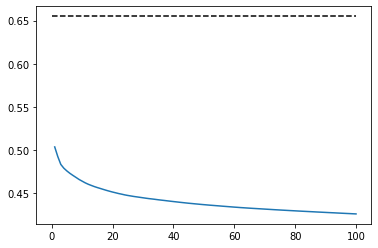

In [79]:
plt.plot(list(range(1, max_k + 1)), perc_same_class)
plt.hlines(0.6551, 0, max_k, color='black', ls='--')

## Scatter Plot PCA 2dim

In [80]:
pca = PCA(n_components=2)

In [81]:
pca.fit(embeddings)

PCA(n_components=2)

In [82]:
emb_2d = pca.transform(embeddings)

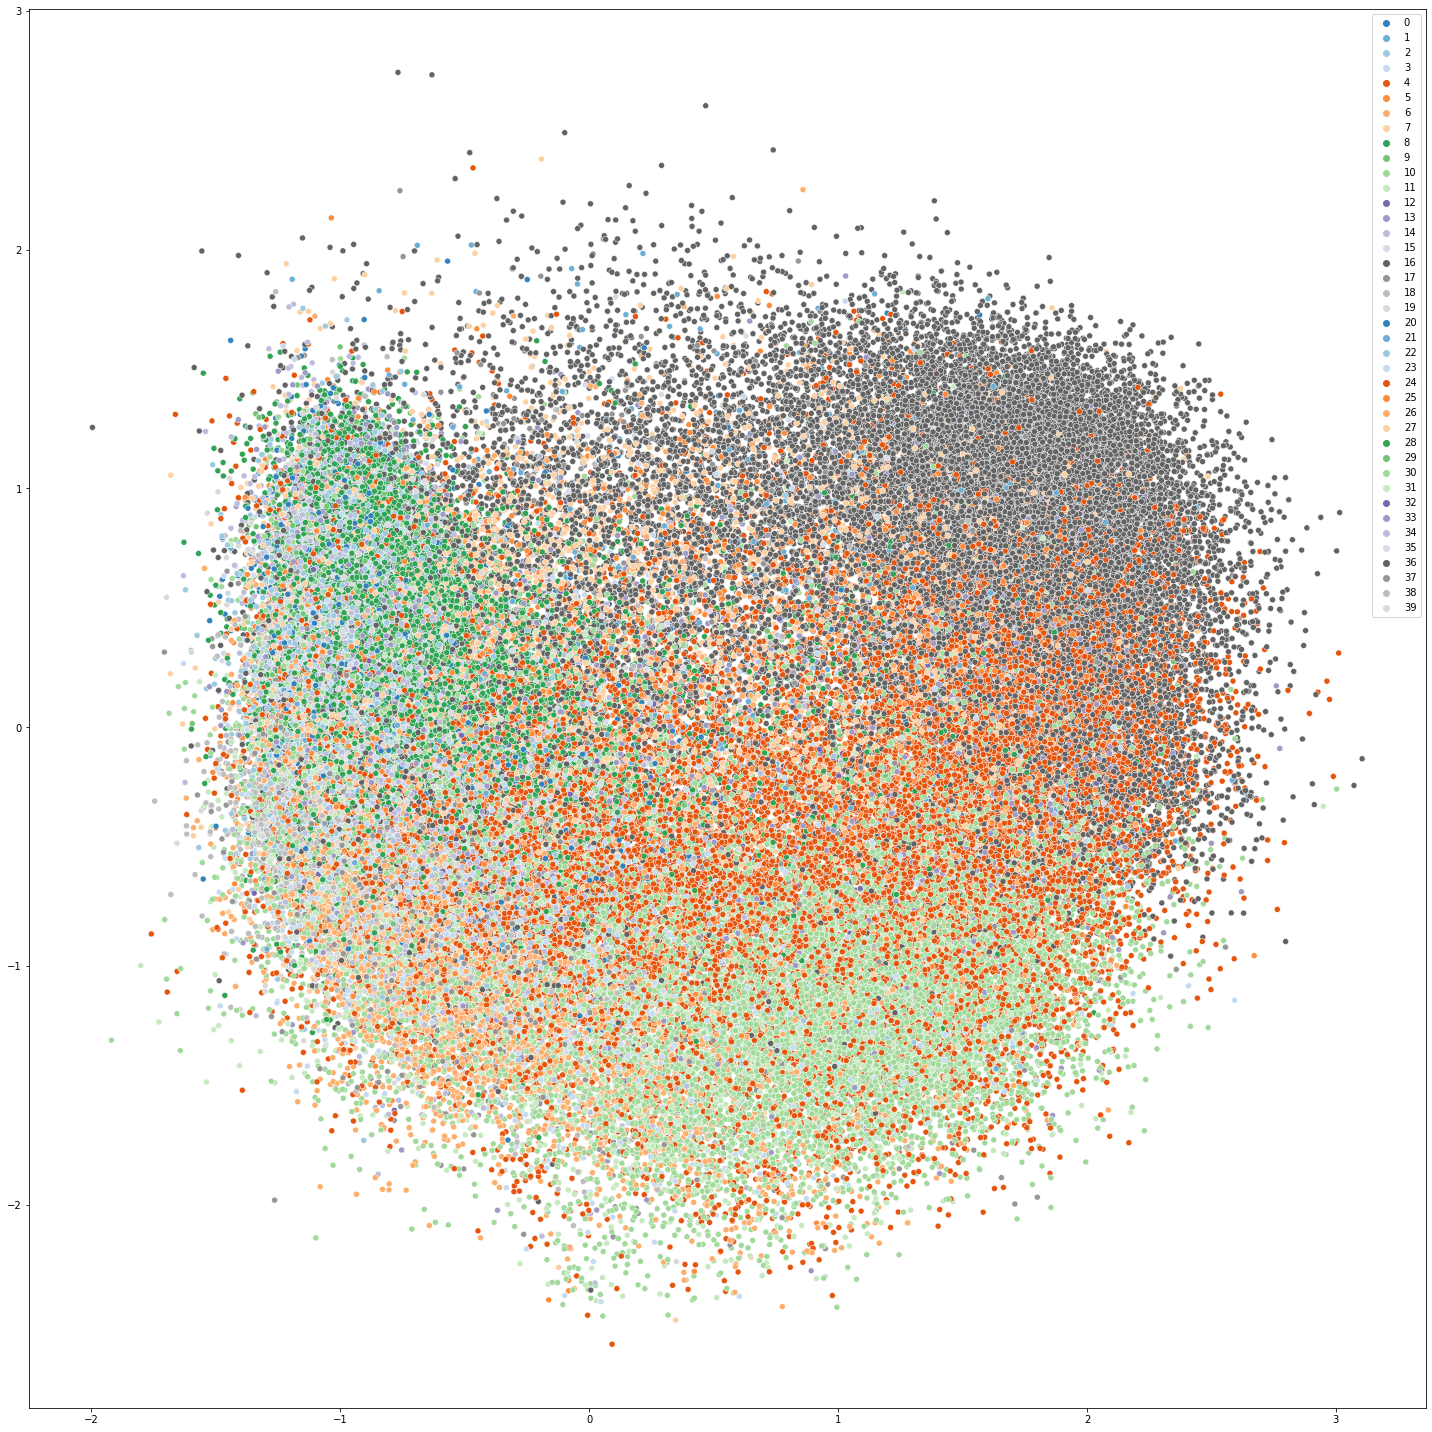

In [83]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_2d[:,0], y=emb_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d

In [84]:
emb_umap_2d = umap.UMAP(n_components=2).fit_transform(embeddings)

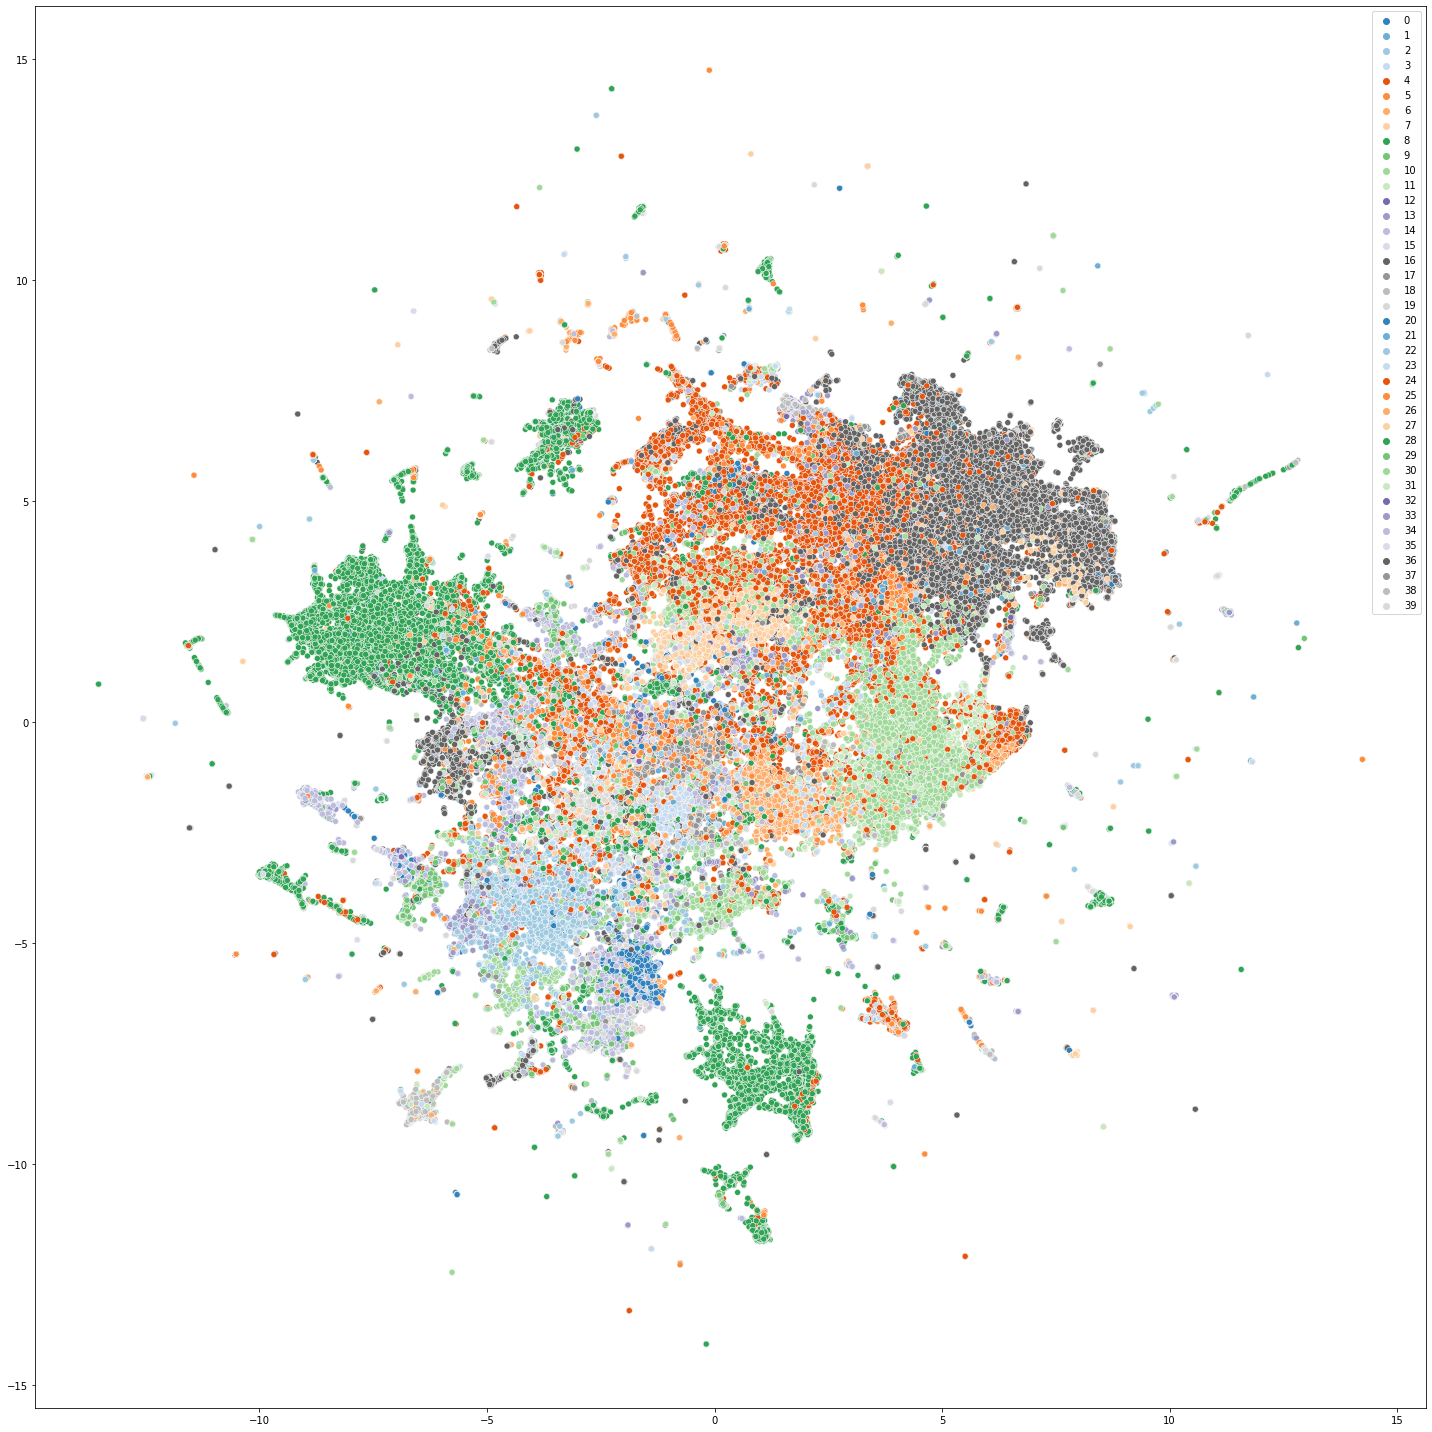

In [85]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d[:,0], y=emb_umap_2d[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()

## Scatter Plot UMAP 2d - Normalized embeddings

In [86]:
emb_umap_2d_norm = umap.UMAP(n_components=2).fit_transform(emb_norm)

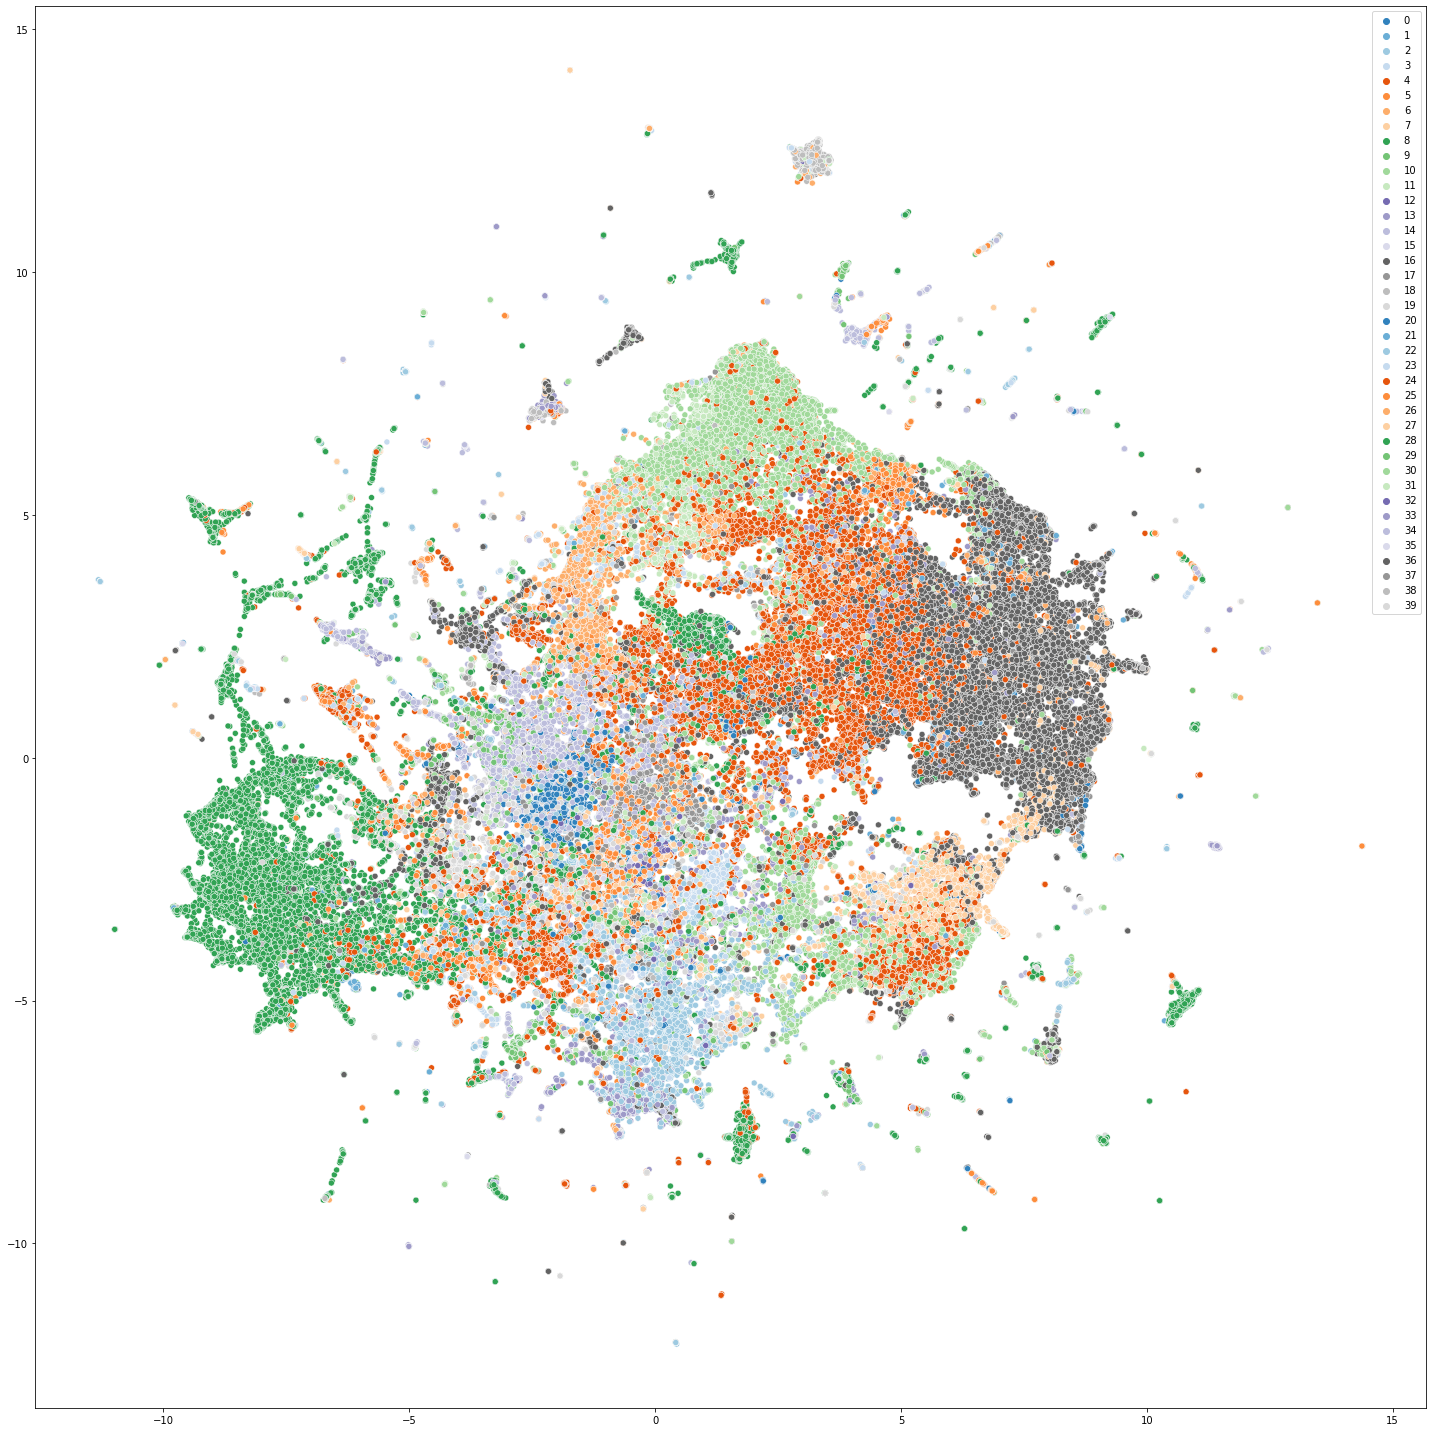

In [87]:
plt.figure(figsize=(20, 20))
sns.scatterplot(x=emb_umap_2d_norm[:,0], y=emb_umap_2d_norm[:,1], hue=dataset[0][1][:,0], palette='tab20c')
plt.tight_layout()